In [1]:
# load paths and classes from src
import os
import sys
from pathlib import Path

# Get the project root directory (one level up from notebooks)
# Use os.getcwd() since __file__ is not available in Jupyter notebooks
_current_dir = Path(os.getcwd())
_project_root = _current_dir.parent if _current_dir.name == "notebooks" else _current_dir
_src_path = _project_root / "src"
_data_path = _src_path / "data"
_models_path = _src_path / "models"

# Add paths to sys.path for imports
for path in [_src_path, _data_path, _models_path]:
    path_str = str(path)
    if path_str not in sys.path:
        sys.path.append(path_str)

print(f"✅ Added paths:")
print(f"   📁 src: {_src_path}")
print(f"   📁 data: {_data_path}")  
print(f"   📁 models: {_models_path}")

# Verify paths exist
for name, path in [("src", _src_path), ("data", _data_path), ("models", _models_path)]:
    if path.exists():
        print(f"   ✅ {name} directory exists")
    else:
        print(f"   ❌ {name} directory not found at {path}")

# Now you can import from these directories
# Example imports:
# from dataset import MCPTennisDataset
# from models import SimpleUnifiedBaseline  

✅ Added paths:
   📁 src: g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src
   📁 data: g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data
   📁 models: g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\models
   ✅ src directory exists
   ✅ data directory exists
   ✅ models directory exists


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
import re
import os
import random

# --- CONFIGURAZIONE GLOBALE ---
SEQ_LEN = 30       # Fixed sequence length
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the path
save_path = 'tennis_shot_forecasting.pth'

# Seed everything to avoid randomness
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    print(f"Random seed set to {seed}")

# Call it immediately
seed_everything(42)

Random seed set to 42


In [3]:
#load datasets
from dataset import MCPTennisDataset, EnhancedTennisDataset, MCPMultiTaskDataset, HierarchicalTennisDataset
from torch.utils.data import DataLoader

base_path = '../dataset/tennis_MatchChartingProject-master/'

# List all point files to merge
point_files = [
    base_path + 'charting-m-points-2020s.csv',
    base_path + 'charting-m-points-2010s.csv',
    base_path + 'charting-m-points-to-2009.csv'
]

# New Matches File
matches_path = base_path  + '/charting-m-matches.csv'

atp_path = '../dataset/atp_players.csv'
wta_path = '../dataset/wta_players.csv'

datasetSingleBaseline = MCPTennisDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 
datasetSingleModel1 = MCPTennisDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 
datasetSingleModel2 = EnhancedTennisDataset(
        points_paths_list=point_files,
        matches_path=matches_path,
        atp_path=atp_path,
        wta_path=wta_path,
        max_seq_len=SEQ_LEN  # Length of rally history to look at
    )
datasetMultiBaseline = MCPMultiTaskDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 
datasetMultiModel = HierarchicalTennisDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 


Initializing Dataset with FULL-SPEC Parsing Logic...


g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies into Unified Tokens (FULL spec)...
Dataset Built. Unique Unified Shots Found: 4406
Initializing Dataset with FULL-SPEC Parsing Logic...


g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies into Unified Tokens (FULL spec)...
Dataset Built. Unique Unified Shots Found: 4406
Initializing Dataset with FULL-SPEC Parsing Logic...


g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies into Unified Tokens (FULL spec)...
Dataset Built. Unique Unified Shots Found: 4406
Decomposing inputs for Rich Embeddings...


g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:630: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:630: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies for Multi-Task Learning...
Data Ready. Samples: 962968
Initializing Dataset with FULL-SPEC Parsing Logic...


g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies into Unified Tokens (FULL spec)...
Dataset Built. Unique Unified Shots Found: 4406
Decomposing Data for Hierarchical Training...


In [4]:
import importlib
import sys

# Import utils directly and reload it
if 'models.utils' in sys.modules:
    importlib.reload(sys.modules['models.utils'])
else:
    # First time import - try direct import from utils
    try:
        import models.utils
        importlib.reload(models.utils)
    except:
        # Fallback: import directly from the utils module
        import utils
        importlib.reload(utils)

# Import functions - try both approaches
try:
    from models.utils import (
        load_unified_lstm,
        load_rich_lstm,
        load_multi_baseline_model,
        load_checkpoint_single_baseline,
        load_hierarchical_checkpoint
    )
except ImportError:
    # Fallback to direct utils import
    from utils import (
        load_unified_lstm,
        load_rich_lstm,
        load_multi_baseline_model,
        load_checkpoint_single_baseline,
        load_hierarchical_checkpoint
    )

print("✅ Functions imported successfully from utils module")

device = "cuda" if torch.cuda.is_available() else "cpu"

# Try alternative loading approach to avoid torch._utils error
try:
    singleBaseline = load_checkpoint_single_baseline(
        filepath="../checkpoints/single_head_baseline.pth", 
        dataset=datasetSingleBaseline,
        device=device
    )
except Exception as e1:
    print(f"⚠️ Primary load failed: {e1}")
    try:
        # Fallback: try different checkpoint path
        singleBaseline = load_checkpoint_single_baseline(
            filepath="../checkpoints/singlehead_best.pt", 
            dataset=datasetSingleBaseline,
            device=device
        )
    except Exception as e2:
        print(f"⚠️ Fallback load also failed: {e2}")
        print("❌ SingleBaseline model could not be loaded")
        singleBaseline = None

singleModel1 = load_unified_lstm(datasetSingleModel1, checkpoint_path="../checkpoints/unified_lstm_model.pth", device=device)
singleModel2, optimizer, ckpt = load_rich_lstm(
    checkpoint_path="../checkpoints/rich_lstm_best.pt",
    dataset=datasetSingleModel2,        # optional but recommended
    device=device,
    load_optimizer=False    # True only if resuming training
)
multiBaseline, optimizer, ckpt = load_multi_baseline_model(
    checkpoint_path="../checkpoints/baseline_multi_best.pt",
    dataset=datasetMultiBaseline,       # optional but recommended for inference
    device=device,
    load_optimizer=False
)
multiModel = load_hierarchical_checkpoint(
    checkpoint_path="../checkpoints/hierarchical_best.pth",
    dataset=datasetMultiModel,      
    device=device,
    load_optimizer=False,
    load_scheduler=False
)

✅ Functions imported successfully from utils module
Loading checkpoint from '../checkpoints/single_head_baseline.pth'...
Model loaded successfully (Epoch 11)
✅ Unified LSTM loaded from ../checkpoints/unified_lstm_model.pth
✅ RichInputLSTM loaded from ../checkpoints/rich_lstm_best.pt
   Epoch: 15 | Val Acc: 24.01%
📦 Vocabularies restored into dataset
✅ Baseline model loaded from ../checkpoints/baseline_multi_best.pt
   Epoch: 12 | Type: 56.78% | Dir: 44.58% | Depth: 73.48%
📦 Vocabularies restored into dataset
📂 Loading checkpoint from: ../checkpoints/hierarchical_best.pth
✅ Vocabularies successfully restored into dataset object.
✔ Model loaded successfully.
   ↳ Checkpoint Epoch: 6
   ↳ Best Val Acc (Avg): 51.92%


🚀 Available models for demo: ['SingleBaseline', 'UnifiedLSTM', 'RichLSTM', 'MultiBaseline', 'HierarchicalGPT']


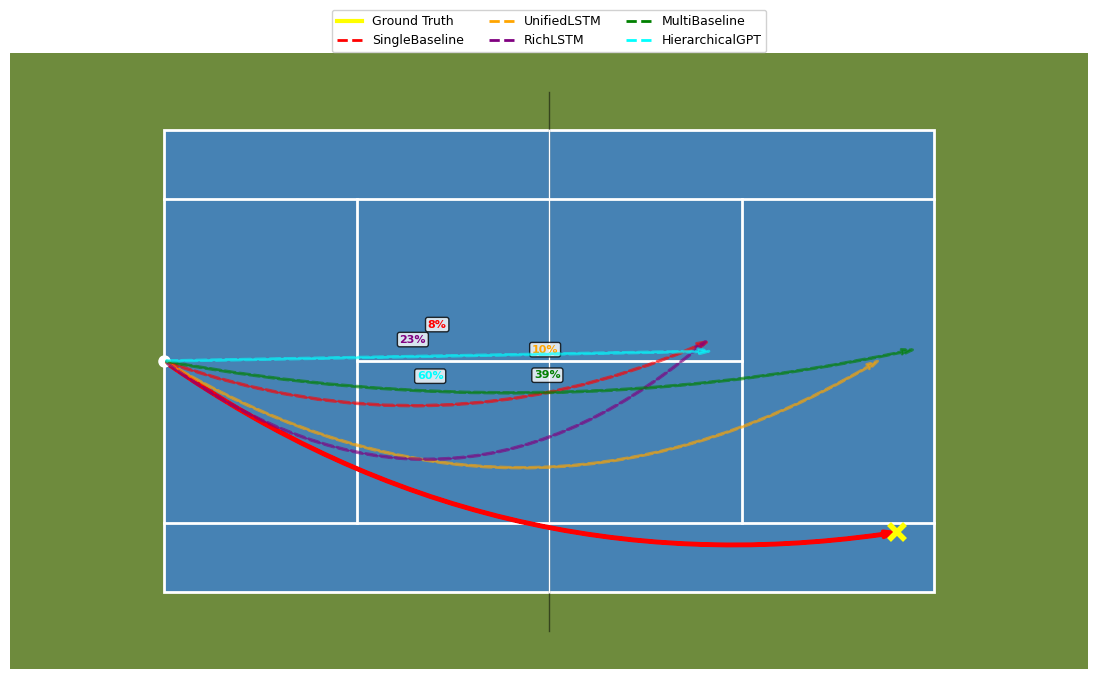

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D
import numpy as np
import random
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- 1. TENNIS LOGIC (WITH DEPTH & PHYSICS) ---
class TennisLogic:
    """Handles logic for a Left-to-Right court view with DEPTH awareness."""
    
    @staticmethod
    def decode_token(token_id, dataset):
        """
        Decodes token into: Type, Direction, and Depth.
        """
        if hasattr(dataset, 'inv_unified_vocab'):
             token_str = dataset.inv_unified_vocab.get(token_id, 'f2')
        else:
            token_str = 'f2'
            
        token_str = str(token_str).strip().lower()
        
        # Defaults
        shot_data = {'type': 'f', 'direction': '2', 'depth': '9', 'is_serve': False}

        # 1. PARSE SERVES
        if token_str and token_str[0] in ['4', '5', '6']:
            shot_data['type'] = 's'
            shot_data['direction'] = token_str[0]
            shot_data['is_serve'] = True
            shot_data['depth'] = '7' 
            return shot_data
            
        # 2. PARSE RALLIES
        if '_' in token_str:
            parts = token_str.split('_')
            shot_data['type'] = parts[0]
            if len(parts) > 1: shot_data['direction'] = parts[1]
            if len(parts) > 2: shot_data['depth'] = parts[2]
        else:
            # Standard "f1" format
            shot_data['type'] = token_str[0]
            for char in token_str:
                if char in ['1', '2', '3']:
                    shot_data['direction'] = char
                    break
        
        # 3. INFER DEPTH IF MISSING
        if shot_data['type'] in ['u', 'y']:
            shot_data['depth'] = '5' # Drop
        elif shot_data['type'] in ['v', 'z', 'h', 'i']:
            shot_data['depth'] = '8' # Volley/Half-Volley (Mid)
            
        return shot_data

    @staticmethod
    def get_target_coordinates(direction, depth, is_serve, hitting_from_left):
        """
        Calculates landing spot X,Y with Jitter.
        """
        # --- FIX: FORCE STRING CONVERSION TO PREVENT TYPE MISMATCH ---
        s_dir = str(direction)
        s_depth = str(depth) 
        # -----------------------------------------------------------

        # Y-AXIS (Width 0-6)
        base_y = 3.0
        if s_dir == '1':   base_y = 1.0
        elif s_dir == '2': base_y = 3.0
        elif s_dir == '3': base_y = 5.0
        elif s_dir == '4': base_y = 1.0 if hitting_from_left else 5.0
        elif s_dir == '5': base_y = 3.0
        elif s_dir == '6': base_y = 3.0
        
        # X-AXIS (Length/Depth)
        if hitting_from_left:
            # Ball moving Left -> Right (Target x > 5)
            if is_serve:
                base_x = 7.0 
            elif s_depth == '5': # Drop shot
                base_x = 5.8 
            elif s_depth == '7': # Short
                base_x = 7.0 
            elif s_depth == '8': # Mid
                base_x = 8.0 
            else: # 9 / Deep
                base_x = 9.5 
        else:
            # Ball moving Right -> Left (Target x < 5)
            if is_serve:
                base_x = 3.0 
            elif s_depth == '5': # Drop shot
                base_x = 4.2 
            elif s_depth == '7': # Short
                base_x = 3.0
            elif s_depth == '8': # Mid
                base_x = 2.0
            else: # 9 / Deep
                base_x = 0.5 # Baseline area

        # Jitter
        jitter_x = random.uniform(-0.3, 0.3)
        jitter_y = random.uniform(-0.3, 0.3)
        
        return (base_x + jitter_x, base_y + jitter_y)
# --- 2. VISUALIZATION ENGINE ---
class TennisCourtVisualizer:
    def __init__(self):
        self.fig, self.ax = plt.subplots(1, 1, figsize=(14, 8))
        self.court_color = '#4682B4'
        self.out_color = '#6E8B3D'
        self.setup_court()

    def setup_court(self):
        self.ax.clear()
        self.ax.set_xlim(-2, 12)
        self.ax.set_ylim(-1, 7)
        self.ax.set_aspect('equal')
        self.ax.axis('off')

        # Background & Court
        self.ax.add_patch(patches.Rectangle((-2, -1), 14, 8, color=self.out_color))
        self.ax.add_patch(patches.Rectangle((0, 0), 10, 6, lw=2, edgecolor='white', facecolor=self.court_color))
        
        # Lines
        # Net
        self.ax.plot([5, 5], [-0.5, 6.5], color='black', lw=1, alpha=0.5) 
        self.ax.plot([5, 5], [0, 6], color='white', lw=1)
        # Service Lines
        self.ax.plot([2.5, 2.5], [0.9, 5.1], color='white', lw=2)
        self.ax.plot([7.5, 7.5], [0.9, 5.1], color='white', lw=2)
        # Center Service
        self.ax.plot([2.5, 7.5], [3, 3], color='white', lw=2)
        # Singles Lines
        self.ax.plot([0, 10], [0.9, 0.9], color='white', lw=2)
        self.ax.plot([0, 10], [5.1, 5.1], color='white', lw=2)

        self.add_legend()

    def add_legend(self):
        legend_elements = [
            Line2D([0], [0], color='yellow', lw=3, label='Ground Truth'),
            Line2D([0], [0], color='red', lw=2, linestyle='--', label='SingleBaseline'),
            Line2D([0], [0], color='orange', lw=2, linestyle='--', label='UnifiedLSTM'),
            Line2D([0], [0], color='purple', lw=2, linestyle='--', label='RichLSTM'),
            Line2D([0], [0], color='green', lw=2, linestyle='--', label='MultiBaseline'),
            Line2D([0], [0], color='cyan', lw=2, linestyle='--', label='HierarchicalGPT')
        ]
        self.ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.08), 
                      ncol=3, framealpha=0.9, fontsize=9)

    def draw_trajectory(self, start, end, is_prediction=False, confidence=None, color='red', model_name=''):
        style = '--' if is_prediction else '-'
        alpha = 0.6 if is_prediction else 1.0
        z = 10 if is_prediction else 5
        linewidth = 2 if is_prediction else 3

        # Markers
        if not is_prediction:
            self.ax.plot(start[0], start[1], 'o', color='white', zorder=z+1, markersize=8)
            self.ax.plot(end[0], end[1], 'x', color='yellow', markersize=12, markeredgewidth=4, zorder=z+1)
        
        # Curvature - vary curvature for different models to avoid overlap
        rad_offset = {'SingleBaseline': 0, 'UnifiedLSTM': 0.1, 'RichLSTM': 0.2, 
                     'MultiBaseline': -0.1, 'HierarchicalGPT': -0.2}
        base_rad = 0.2 if start[0] < end[0] else -0.2
        rad = base_rad + rad_offset.get(model_name, 0)
        
        arrow = FancyArrowPatch(start, end, connectionstyle=f"arc3,rad={rad}", 
                                arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8",
                                color=color, linestyle=style, alpha=alpha, zorder=z, linewidth=linewidth)
        self.ax.add_patch(arrow)
        
        if is_prediction and confidence is not None:
            # Offset text positions to avoid overlap
            text_offset = {'SingleBaseline': (0, 0.3), 'UnifiedLSTM': (0.3, 0.1), 
                          'RichLSTM': (-0.3, 0.1), 'MultiBaseline': (0.1, -0.3), 
                          'HierarchicalGPT': (-0.1, -0.3)}
            
            mid_x = (start[0] + end[0]) / 2
            mid_y = (start[1] + end[1]) / 2
            offset = text_offset.get(model_name, (0, 0))
            label_x = mid_x + offset[0]
            label_y = mid_y + offset[1]
            
            self.ax.text(label_x, label_y, f"{int(confidence)}%", color=color, fontsize=8, fontweight='bold',
                        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, pad=0.2))

# --- 3. CONTROLLER ---
class TennisRallyDemo:
    def __init__(self, models, datasets):
        self.models = models
        self.datasets = datasets
        
        # Fallback vocabs
        self.fallback_vocabs = {
            'type': {k: v for v, k in enumerate(['<pad>', '<unk>', 'serve', 'f', 'b', 'r', 's', 'v', 'z', 'o', 'p', 'u', 'y', 'l', 'm', 'h', 'i', 'j', 'k', 't', 'q', 'special', 'let'])},
            'dir': {k: v for v, k in enumerate(['<pad>', '0', '1', '2', '3'])},
            'depth': {k: v for v, k in enumerate(['<pad>', '0', '7', '8', '9'])}
        }
        
        self.main_dataset = list(datasets.values())[0] if datasets else None
        self.test_indices = list(range(min(1000, len(self.main_dataset)))) if self.main_dataset else []
        
        self.viz = TennisCourtVisualizer()
        
        self.current_rally_idx = None
        self.step_idx = 0
        self.valid_indices = []
        self.ball_pos = (0, 3) 
        self.hitting_from_left = True 
        
        self.model_colors = {
            'SingleBaseline': 'red',
            'UnifiedLSTM': 'orange', 
            'RichLSTM': 'purple',
            'MultiBaseline': 'green',
            'HierarchicalGPT': 'cyan'
        }
        
        self.setup_ui()
        
    def setup_ui(self):
        self.out_info = widgets.Output()
        self.out_viz = widgets.Output()
        
        self.btn_load = widgets.Button(description='🎾 New Rally', button_style='success')
        self.btn_next = widgets.Button(description='▶️ Next Shot', button_style='primary')
        
        # Model selection checkboxes
        self.model_checks = {}
        for model_name in self.models.keys():
            if self.models[model_name] is not None:
                chk = widgets.Checkbox(value=True, description=model_name)
                # --- NEW: Bind the change event to the redraw function ---
                chk.observe(self.on_check_change, names='value') 
                self.model_checks[model_name] = chk
        
        self.btn_load.on_click(self.load_rally)
        self.btn_next.on_click(self.next_step)
        
        model_box = widgets.HBox(list(self.model_checks.values()))
        control_box = widgets.HBox([self.btn_load, self.btn_next])
        
        display(widgets.VBox([
            widgets.HTML("<h3>🎾 Tennis Shot Prediction Demo</h3>"),
            widgets.HTML("<b>Select Models to Compare:</b>"),
            model_box,
            control_box,
            widgets.HBox([self.out_info, self.out_viz])
        ]))
        self.load_rally(None)

    # --- NEW: Handler for checkbox changes ---
    def on_check_change(self, change):
        """Called immediately when a checkbox is ticked/unticked"""
        self.update_visualization()

    def _get_input_seq(self, data):
        if 'input' in data: return data['input']
        elif 'x_seq' in data: return data['x_seq']
        return list(data.values())[0]

    def load_rally(self, b):
        if not self.main_dataset: return
            
        self.current_rally_idx = random.choice(self.test_indices)
        rally_data = self.main_dataset[self.current_rally_idx]
        
        try:
            seq = self._get_input_seq(rally_data)
            self.valid_indices = (seq != 0).nonzero(as_tuple=True)[0].tolist()
            
            if len(self.valid_indices) < 2:
                self.load_rally(None)
                return

            self.step_idx = 0
            self.ball_pos = (0, 3) 
            self.hitting_from_left = True
            self.update_visualization()
        except KeyError as e:
            with self.out_info: print(f"❌ Error loading rally: {e}")

    def next_step(self, b):
        if self.step_idx >= len(self.valid_indices) - 1:
            with self.out_info: 
                clear_output(wait=True)
                print("🏁 Rally Finished! Click 'New Rally'")
            return
            
        prev_idx = self.valid_indices[self.step_idx]
        rally_data = self.main_dataset[self.current_rally_idx]
        seq = self._get_input_seq(rally_data)
        prev_token = seq[prev_idx].item()
        
        prev_info = TennisLogic.decode_token(prev_token, self.main_dataset)
        target_x, target_y = TennisLogic.get_target_coordinates(
            prev_info['direction'], prev_info['depth'], prev_info['is_serve'], self.hitting_from_left
        )
        self.ball_pos = (target_x, target_y)
        self.hitting_from_left = not self.hitting_from_left
        
        self.step_idx += 1
        self.update_visualization()

    def get_model_prediction(self, model_name, model, dataset, data, curr_idx):
        """Updated prediction logic using curr_idx for correct left-padding handling"""
        if model is None: return None, 0
            
        try:
            with torch.no_grad():
                model.eval()
                inputs = {}
                x_c = data['context'].unsqueeze(0).to(DEVICE)
                
                # --- HierarchicalGPT ---
                if 'Hierarchical' in model_name:
                    if 'x_type' not in data: return None, 0
                    inputs['x_z'] = data['x_dir'].unsqueeze(0).to(DEVICE)
                    inputs['x_t'] = data['x_type'].unsqueeze(0).to(DEVICE)
                    inputs['x_c'] = x_c
                    s_id = data['x_s_id'] if isinstance(data['x_s_id'], torch.Tensor) else torch.tensor([data['x_s_id']])
                    r_id = data['x_r_id'] if isinstance(data['x_r_id'], torch.Tensor) else torch.tensor([data['x_r_id']])
                    inputs['x_s'] = s_id.reshape(1).to(DEVICE)
                    inputs['x_r'] = r_id.reshape(1).to(DEVICE)
                    
                    l_dir, l_depth, l_type = model(**inputs)
                    t = min(curr_idx, l_type.size(1) - 1)
                    return self._process_multi_head_output(l_type[:, t], l_dir[:, t], l_depth[:, t], dataset)
                    
                # --- RichLSTM ---
                elif 'Rich' in model_name and 'x_type' in data:
                    inputs['x_type'] = data['x_type'].unsqueeze(0).to(DEVICE)
                    inputs['x_dir'] = data['x_dir'].unsqueeze(0).to(DEVICE)
                    inputs['x_depth'] = data['x_depth'].unsqueeze(0).to(DEVICE)
                    inputs['x_s_id'] = data['x_s_id'].unsqueeze(0).to(DEVICE)
                    inputs['x_r_id'] = data['x_r_id'].unsqueeze(0).to(DEVICE)
                    inputs['x_context'] = x_c
                    logits = model(**inputs)
                    t = min(curr_idx, logits.size(1) - 1)
                    probs = torch.softmax(logits[0, t], dim=0)
                    conf, pred_id = probs.max(dim=0)
                    return TennisLogic.decode_token(pred_id.item(), dataset), conf.item() * 100
                    
                # --- MultiBaseline ---
                elif 'Multi' in model_name:
                    x_seq = self._get_input_seq(data).unsqueeze(0).to(DEVICE)
                    l_type, l_dir, l_depth = model(x_seq, x_c)
                    t = min(curr_idx, l_type.size(1) - 1)
                    return self._process_multi_head_output(l_type[:, t], l_dir[:, t], l_depth[:, t], dataset)
                    
                # --- SingleBaseline / UnifiedLSTM ---
                else:
                    x_seq = self._get_input_seq(data).unsqueeze(0).to(DEVICE)
                    logits = model(x_seq, x_c)
                    t = min(curr_idx, logits.size(1) - 1)
                    probs = torch.softmax(logits[0, t], dim=0)
                    conf, pred_id = probs.max(dim=0)
                    return TennisLogic.decode_token(pred_id.item(), dataset), conf.item() * 100
                
        except Exception as e:
            return None, 0

    def _process_multi_head_output(self, l_type, l_dir, l_depth, dataset):
        p_type, p_dir, p_depth = torch.softmax(l_type[0], dim=0), torch.softmax(l_dir[0], dim=0), torch.softmax(l_depth[0], dim=0)
        
        conf_t, id_t = p_type.max(0)
        conf_d, id_d = p_dir.max(0)
        conf_dp, id_dp = p_depth.max(0)
        
        # Get vocabs with fallback
        inv_type = {v: k for k, v in getattr(dataset, 'type_vocab', self.fallback_vocabs['type']).items()}
        inv_dir = {v: k for k, v in getattr(dataset, 'dir_vocab', self.fallback_vocabs['dir']).items()}
        inv_depth = {v: k for k, v in getattr(dataset, 'depth_vocab', self.fallback_vocabs['depth']).items()}
        
        str_type = inv_type.get(id_t.item(), 'f')
        str_dir = inv_dir.get(id_d.item(), '2')
        str_depth = inv_depth.get(id_dp.item(), '9')
        
        # --- FIX: SANITIZE "0" or "<pad>" PREDICTIONS ---
        if str(str_dir) in ['0', '<pad>']: str_dir = '2'   # Default to Center
        if str(str_depth) in ['0', '<pad>']: str_depth = '9' # Default to Deep
        # ------------------------------------------------
        
        pred_info = {
            'type': str_type,
            'direction': str_dir,
            'depth': str_depth,
            'is_serve': (str_type == 'serve' or str_type == 's')
        }
        
        if pred_info['type'] == 'serve': pred_info['type'] = 's'
        
        conf = (conf_t + conf_d + conf_dp) / 3 * 100
        return pred_info, conf

    def update_visualization(self):
        data = self.main_dataset[self.current_rally_idx]
        curr_idx = self.valid_indices[self.step_idx] if self.step_idx < len(self.valid_indices) else self.valid_indices[-1]
        
        # 1. Decode Ground Truth
        seq = self._get_input_seq(data)
        token_id = seq[curr_idx].item()
        shot_info = TennisLogic.decode_token(token_id, self.main_dataset)
        target_pos = TennisLogic.get_target_coordinates(
            shot_info['direction'], shot_info['depth'], shot_info['is_serve'], self.hitting_from_left
        )

        # 2. Get Predictions (Only for ticked boxes)
        predictions = {}
        for model_name, checkbox in self.model_checks.items():
            if checkbox.value and self.models[model_name] is not None:
                model_dataset = self.datasets.get(model_name, self.main_dataset)
                try: model_data = model_dataset[self.current_rally_idx]
                except: model_data = data 

                pred_info, conf = self.get_model_prediction(
                    model_name, self.models[model_name], model_dataset, model_data, curr_idx
                )
                if pred_info: predictions[model_name] = (pred_info, conf)

        # 3. Draw
        with self.out_viz:
            clear_output(wait=True)
            self.viz.setup_court()
            self.viz.draw_trajectory(self.ball_pos, target_pos, is_prediction=False)
            
            for model_name, (pred_info, conf) in predictions.items():
                pred_target_pos = TennisLogic.get_target_coordinates(
                    pred_info['direction'], pred_info['depth'], pred_info['is_serve'], self.hitting_from_left
                )
                color = self.model_colors.get(model_name, 'gray')
                self.viz.draw_trajectory(self.ball_pos, pred_target_pos, is_prediction=True, 
                                        confidence=conf, color=color, model_name=model_name)
            display(self.viz.fig)
            
        # 4. Info
        with self.out_info:
            clear_output(wait=True)
            print(f"🎾 Rally: {self.current_rally_idx} | Step: {self.step_idx + 1}/{len(self.valid_indices)}")
            print(f"🎯 Ground Truth: {shot_info['type'].upper()} (Dir {shot_info['direction']}, Depth {shot_info['depth']})")
            print("="*40)
            for model_name, (pred_info, conf) in predictions.items():
                d_match = "✅" if (pred_info['direction'] == shot_info['direction']) else "❌"
                t_match = "✅" if (pred_info['type'] == shot_info['type']) else "❌"
                print(f"{model_name}:")
                print(f"  Pred: {pred_info['type'].upper()} (D:{pred_info['direction']}, L:{pred_info['depth']})")
                print(f"  Conf: {int(conf)}% | Dir:{d_match} Typ:{t_match}\n")

 
# Create the demo with all loaded models
def extract_model(model_var):
    """Helper to extract model from tuple if needed"""
    if isinstance(model_var, tuple):
        return model_var[0]  # Return just the model from (model, optimizer, checkpoint)
    return model_var

available_models = {
    'SingleBaseline': extract_model(globals().get('singleBaseline', None)),
    'UnifiedLSTM': extract_model(globals().get('singleModel1', None)), 
    'RichLSTM': extract_model(globals().get('singleModel2', None)),
    'MultiBaseline': extract_model(globals().get('multiBaseline', None)),
    'HierarchicalGPT': extract_model(globals().get('multiModel', None))
}

available_datasets = {
    'SingleBaseline': globals().get('datasetSingleBaseline', None),
    'UnifiedLSTM': globals().get('datasetSingleModel1', None),
    'RichLSTM': globals().get('datasetSingleModel2', None), 
    'MultiBaseline': globals().get('datasetMultiBaseline', None),
    'HierarchicalGPT': globals().get('datasetMultiModel', None)
}

# Filter out None models and datasets
working_models = {k: v for k, v in available_models.items() if v is not None}
working_datasets = {k: v for k, v in available_datasets.items() if v is not None}

print(f"🚀 Available models for demo: {list(working_models.keys())}")

if working_models and working_datasets:
    demo = TennisRallyDemo(working_models, working_datasets)
else:
    print("❌ No models available. Please run the model loading cells first.")